<a href="https://colab.research.google.com/github/toshi47/NER/blob/main/simple_autoencoder_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Simple autoencoder**

Loading dataset from google drive.

In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')
# Single fully-connected neural layer as encoder and decoder
df = pd.read_csv('/content/drive//My Drive/NER/my_small.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
display(df)
original_dim= df.shape[1]-2
print(original_dim)
input_shape = (original_dim, )
intermediate_dim = int(original_dim/2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,word,sent_id,word_id_in_sent,head_id,part_of_speech_ADP,part_of_speech_ADV,part_of_speech_AUX,part_of_speech_CCONJ,part_of_speech_DET,part_of_speech_INTJ,...,Person_1,Person_2,Person_3,Polarity_0,Polarity_Neg,Foreign_0,Foreign_Yes,Hyph_0,Hyph_Yes,tag
0,Вице-премьер,0,1,7,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,O
1,по,0,2,4,1,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,O
2,социальным,0,3,4,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,O
3,вопросам,0,4,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,O
4,Татьяна,0,5,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,B-PER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183223,компенсации,1004,31,27,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,O
183224,за,1004,32,33,1,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,O
183225,плату,1004,33,31,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,O
183226,коммунальных,1004,34,35,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,O


113


In [2]:
use_regularizer = False
my_regularizer = None
my_epochs = 100

if use_regularizer:
    # add a sparsity constraint on the encoded representations
    # note use of 10e-5 leads to blurred results
    my_regularizer = regularizers.l1(10e-8)
    # and a larger number of epochs as the added regularization the model
    # is less likely to overfit and can be trained longer
    my_epochs = 100

Creating model.

In [3]:
# this is the size of our encoded representations
encoding_dim = int(original_dim/2)  

# this is our input placeholder;
input_img = Input(shape=input_shape)

# "encoded" is the encoded representation of the inputs
encoded = Dense(encoding_dim, activation='relu', activity_regularizer=my_regularizer)(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(original_dim, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# Separate Encoder model

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# Separate Decoder model

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))


# configure model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Prepare input data, dropping insignificant columns and then normalize dataset. Initialize target vector encodding.

In [4]:
scaler = MinMaxScaler()
df_values = df.drop(columns=['word', 'tag'], axis=1)
df_norm = scaler.fit_transform(df_values)
tags=df['tag'].unique()
le = LabelEncoder()
le.fit(tags)
encoded_tags=le.transform(tags)
print(tags)
print(encoded_tags)


['O' 'B-PER' 'I-PER' 'B-LOC' 'B-ORG' 'I-ORG' 'I-LOC']
[6 2 5 0 1 4 3]


Train autoencoder, after 50???/100 epochs the autoencoder seems to reach a stable train/test lost value.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df_norm, df_norm,
                                                    test_size=0.33, random_state=42)

# Train autoencoder for 50 epochs

hist=autoencoder.fit(x_train, x_train, epochs=my_epochs, batch_size=256, shuffle=True, validation_data=(x_test, x_test),
                verbose=2)

Epoch 1/100
480/480 - 8s - loss: 0.6891 - val_loss: 0.6869 - 8s/epoch - 16ms/step
Epoch 2/100
480/480 - 4s - loss: 0.6846 - val_loss: 0.6821 - 4s/epoch - 9ms/step
Epoch 3/100
480/480 - 4s - loss: 0.6795 - val_loss: 0.6768 - 4s/epoch - 8ms/step
Epoch 4/100
480/480 - 4s - loss: 0.6740 - val_loss: 0.6712 - 4s/epoch - 9ms/step
Epoch 5/100
480/480 - 4s - loss: 0.6682 - val_loss: 0.6652 - 4s/epoch - 8ms/step
Epoch 6/100
480/480 - 5s - loss: 0.6622 - val_loss: 0.6590 - 5s/epoch - 11ms/step
Epoch 7/100
480/480 - 3s - loss: 0.6558 - val_loss: 0.6524 - 3s/epoch - 7ms/step
Epoch 8/100
480/480 - 4s - loss: 0.6490 - val_loss: 0.6455 - 4s/epoch - 8ms/step
Epoch 9/100
480/480 - 4s - loss: 0.6419 - val_loss: 0.6383 - 4s/epoch - 9ms/step
Epoch 10/100
480/480 - 3s - loss: 0.6345 - val_loss: 0.6306 - 3s/epoch - 7ms/step
Epoch 11/100
480/480 - 4s - loss: 0.6266 - val_loss: 0.6225 - 4s/epoch - 8ms/step
Epoch 12/100
480/480 - 2s - loss: 0.6183 - val_loss: 0.6140 - 2s/epoch - 4ms/step
Epoch 13/100
480/480 - 

In [6]:
def plt_hist(hist):
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

**Loss function visualization**

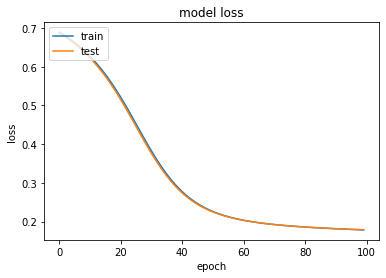

In [7]:
plt_hist(hist)

**Encoding our data**

Encode some vectors from test set, then decode them.


In [8]:
encoded_vec = encoder.predict(x_test)
print(encoded_vec.shape)
display(encoded_vec)
decoded_vec = decoder.predict(encoded_vec)
print(decoded_vec.shape)
display(decoded_vec)

(60466, 56)


array([[3.272992  , 0.62617743, 3.8520858 , ..., 1.6071643 , 0.        ,
        0.        ],
       [3.2797225 , 1.0548772 , 4.6177354 , ..., 1.9850055 , 0.        ,
        0.        ],
       [3.0365808 , 1.3093429 , 3.8307178 , ..., 1.542465  , 0.        ,
        0.11462697],
       ...,
       [2.978989  , 1.0428047 , 4.142829  , ..., 1.6044472 , 0.        ,
        0.        ],
       [2.8231032 , 1.3173429 , 4.0355296 , ..., 0.87199104, 0.        ,
        0.07406573],
       [2.6263435 , 1.3829356 , 3.555982  , ..., 0.74448603, 0.        ,
        0.08332799]], dtype=float32)

(60466, 113)


array([[0.43433833, 0.13269967, 0.11015695, ..., 0.02382046, 0.9704832 ,
        0.01950359],
       [0.48543933, 0.12012044, 0.13140157, ..., 0.02265716, 0.98547256,
        0.01444712],
       [0.46419394, 0.1238507 , 0.10296911, ..., 0.02740097, 0.97764754,
        0.01832253],
       ...,
       [0.5095848 , 0.09878916, 0.12071201, ..., 0.02634799, 0.9816619 ,
        0.01230624],
       [0.52596545, 0.11622334, 0.12215376, ..., 0.02738285, 0.974223  ,
        0.0161221 ],
       [0.48012453, 0.11729237, 0.12526542, ..., 0.03144905, 0.9751687 ,
        0.02161974]], dtype=float32)

Encode all data and visualize first 60000. Looks like a shit...

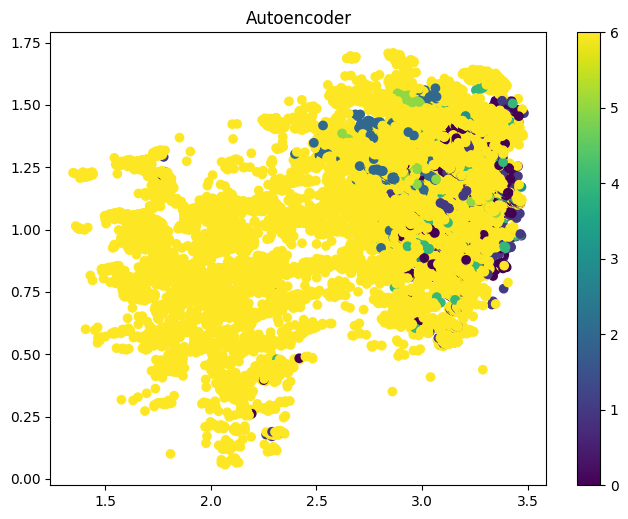

In [9]:
encoded_df=encoder.predict(df_norm)
decoded_df= decoder.predict(encoded_df)
display_df=encoded_df[:60000]
plt.figure(figsize=(8, 6), dpi=100)
colors=le.transform(df['tag'])[:60000]
plt.scatter(display_df[:, 0], display_df[:, 1], c=colors)
plt.title('Autoencoder')
plt.colorbar()
plt.show()

**PCA visualization**

Since our latent space is not two-dimensional, we will use PCA to reduce dimensionality, so we can use some interesting visualizations that can be made at this point. One is to look at the neighborhoods of different classes in the latent 2D plane.

Projecting 113-dimensional data to 2D


Text(0.5, 1.0, 'NER. PCA projection')

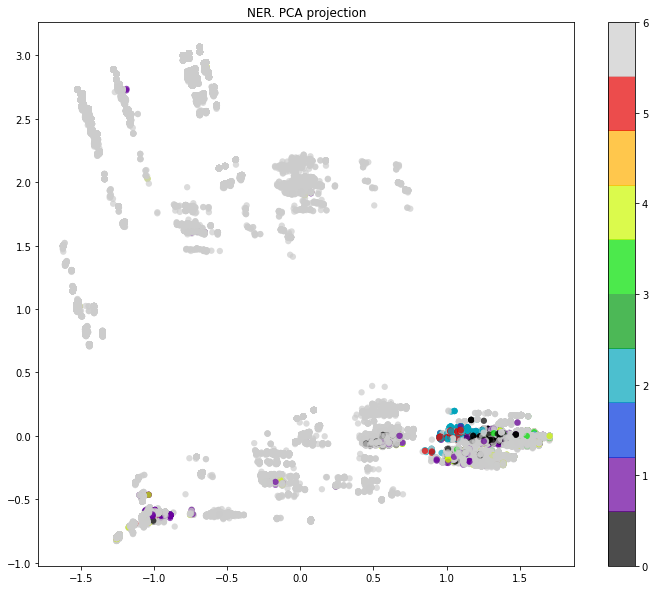

In [10]:
from sklearn.decomposition import PCA
pca      = PCA(n_components=2)
x_reduce = pca.fit_transform(df_norm)
print('Projecting %d-dimensional data to 2D' % df_norm.shape[1])
y=le.transform(df['tag'])
plt.figure(figsize=(12,10))
plt.scatter(x_reduce[:, 0], x_reduce[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('NER. PCA projection')


**TSNE visualization**

TSNE has some troubles and works too long:(

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 183228 samples in 0.013s...
[t-SNE] Computed neighbors for 183228 samples in 859.803s...
[t-SNE] Computed conditional probabilities for sample 1000 / 183228
[t-SNE] Computed conditional probabilities for sample 2000 / 183228
[t-SNE] Computed conditional probabilities for sample 3000 / 183228
[t-SNE] Computed conditional probabilities for sample 4000 / 183228
[t-SNE] Computed conditional probabilities for sample 5000 / 183228
[t-SNE] Computed conditional probabilities for sample 6000 / 183228
[t-SNE] Computed conditional probabilities for sample 7000 / 183228
[t-SNE] Computed conditional probabilities for sample 8000 / 183228
[t-SNE] Computed conditional probabilities for sample 9000 / 183228
[t-SNE] Computed conditional probabilities for sample 10000 / 183228
[t-SNE] Computed conditional probabilities for sample 11000 / 183228
[t-SNE] Computed conditional probabilities for sample 12000 / 183228
[t-SNE] Computed conditional prob

Text(0.5, 1.0, 'NER. t-SNE projection')

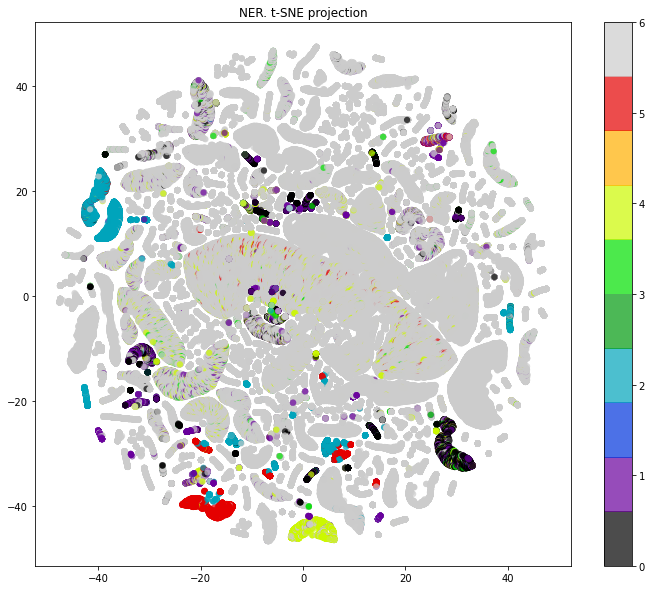

In [11]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
X=encoded_df
X_tsne = tsne.fit_transform(X)
plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('NER. t-SNE projection')

**K-Means Clustering**

Trying to cluster our data. Before we implement the k-means and assign the centers of our data, we can also make a quick analyze to find the optimal number (centers) of clusters using Elbow Method. Optimal number is 5 for all datasets.

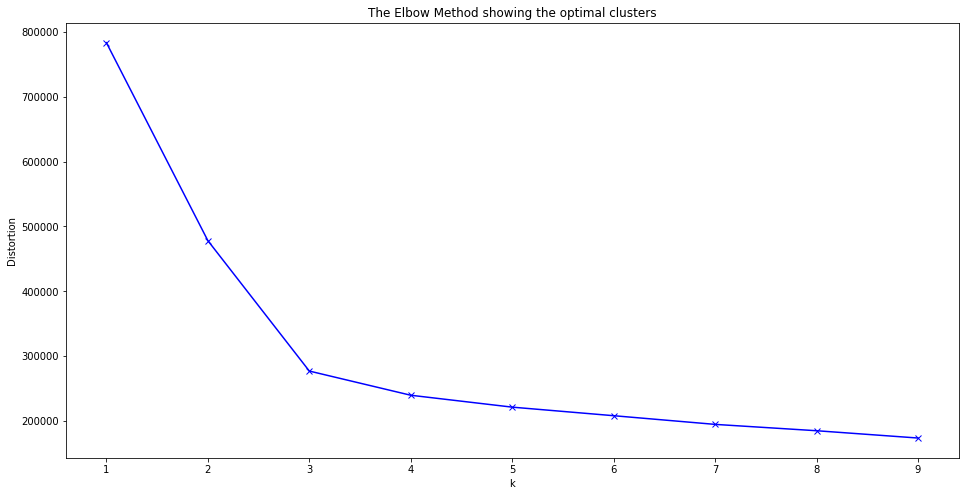

In [12]:
from sklearn.cluster import KMeans
X=encoded_df #df_norm, decoded_df
# Collecting the distortions into list
distortions = []
K = range(1,10)
for k in K:
 kmeanModel = KMeans(n_clusters=k)
 kmeanModel.fit(X)
 distortions.append(kmeanModel.inertia_)
# Plotting the distortions
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal clusters')
plt.show()

In [13]:
# Define the model
kmeans_model = KMeans(n_clusters=5, random_state=32932)
# Fit into our dataset fit
kmeans_predict = kmeans_model.fit_predict(X)
df['Cluster'] = kmeans_predict
display(df.head(20))

,word,sent_id,word_id_in_sent,head_id,part_of_speech_ADP,part_of_speech_ADV,part_of_speech_AUX,part_of_speech_CCONJ,part_of_speech_DET,part_of_speech_INTJ,...,Person_2,Person_3,Polarity_0,Polarity_Neg,Foreign_0,Foreign_Yes,Hyph_0,Hyph_Yes,tag,Cluster
0,Вице-премьер,0,1,7,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,O,1
1,по,0,2,4,1,0,0,0,0,0,...,0,0,1,0,1,0,1,0,O,4
2,социальным,0,3,4,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,O,3
3,вопросам,0,4,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,O,1
4,Татьяна,0,5,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,B-PER,3
5,Голикова,0,6,5,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,I-PER,3
6,рассказала,0,7,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,O,2
7,",",0,8,13,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,O,0
8,в,0,9,11,1,0,0,0,0,0,...,0,0,1,0,1,0,1,0,O,4
9,каких,0,10,11,0,0,0,0,1,0,...,0,0,1,0,1,0,1,0,O,3


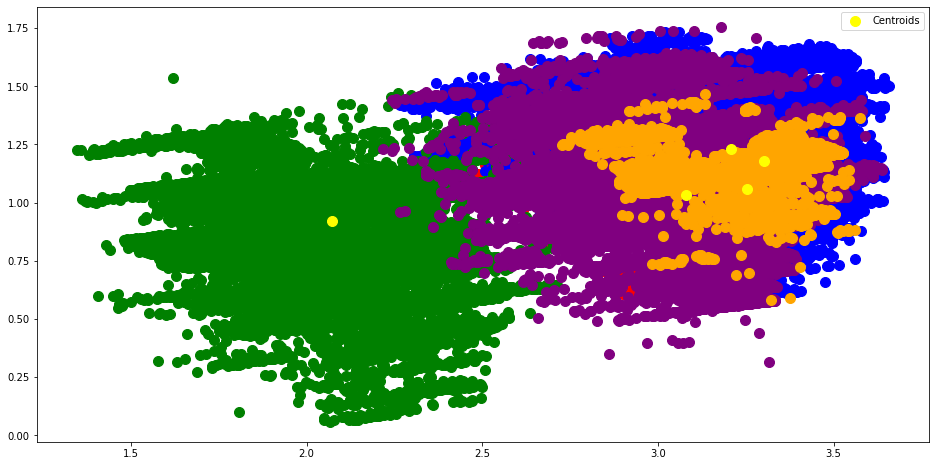

In [14]:
# Visualising the clusters
plt.figure(figsize=(16,8))
plt.scatter(X[kmeans_predict == 0, 0], X[kmeans_predict == 0, 1], s = 100, c = 'red')
plt.scatter(X[kmeans_predict == 1, 0], X[kmeans_predict == 1, 1], s = 100, c = 'blue')
plt.scatter(X[kmeans_predict == 2, 0], X[kmeans_predict == 2, 1], s = 100, c = 'green')
plt.scatter(X[kmeans_predict == 3, 0], X[kmeans_predict == 3, 1], s = 100, c = 'purple')
plt.scatter(X[kmeans_predict == 4, 0], X[kmeans_predict == 4, 1], s = 100, c = 'orange')
# Plotting the centroids of the clusters
plt.scatter(kmeans_model.cluster_centers_[:, 0], kmeans_model.cluster_centers_[:,1], s = 100, c = 'yellow', label = 'Centroids')
plt.legend()

**RandomForest**

Try running RandomForest with differet data. Accuracy is about ~95% for all datasets.

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
X=encoded_df#encoded_df,df_norm
Y=df['tag']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=10, test_size=0.2)
model = RandomForestClassifier()#import random forest


model.fit(X_train, Y_train)#train model

print('prediction:')
y_pred = model.predict(X_test)
print(y_pred)
print()

print('Score:')
score = model.score(X_test,Y_test)
print(score)

print('program end...')
print()


print("Classifiction Report :")
print(classification_report(Y_test, y_pred))
print("Confusion matrix :")
print(confusion_matrix(Y_test, y_pred))
filename = "trained_model.sav"
#pickle.dump(model, open(filename, 'wb')) #save trained model



prediction:
['O' 'O' 'O' ... 'O' 'O' 'O']

Score:
0.9469246302461387
program end...

Classifiction Report :
              precision    recall  f1-score   support

       B-LOC       0.66      0.66      0.66       914
       B-ORG       0.53      0.43      0.48       865
       B-PER       0.94      0.95      0.94       787
       I-LOC       0.20      0.04      0.07       126
       I-ORG       0.55      0.27      0.36       718
       I-PER       0.93      0.83      0.88       527
           O       0.97      0.99      0.98     32709

    accuracy                           0.95     36646
   macro avg       0.68      0.60      0.62     36646
weighted avg       0.94      0.95      0.94     36646

Confusion matrix :
[[  606   134     4     3    15     0   152]
 [  160   372     2     5    28     4   294]
 [    4    10   749     0     1     8    15]
 [   31     7     0     5     4     1    78]
 [   34    29     7     4   192     2   450]
 [    0     9    18     0     5   438    57]
 [   8

**SVM**

In [16]:
from sklearn.svm import SVC # "Support vector classifier"  
model = SVC(kernel='linear', random_state=0)   
model.fit(X_train, Y_train)#train model

print('prediction:')
y_pred = model.predict(X_test)
print(y_pred)
print()

print('Score:')
score = model.score(X_test,Y_test)
print(score)

print('program end...')
print()


print("Classifiction Report :")
print(classification_report(Y_test, y_pred))
print("Confusion matrix :")
print(confusion_matrix(Y_test, y_pred))
filename = "trained_model.sav"
#pickle.dump(model, open(filename, 'wb')) #save trained model

prediction:
['O' 'O' 'O' ... 'O' 'O' 'O']

Score:
0.9488347977951209
program end...

Classifiction Report :


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-LOC       0.62      0.74      0.67       914
       B-ORG       0.57      0.44      0.50       865
       B-PER       0.94      0.97      0.95       787
       I-LOC       0.00      0.00      0.00       126
       I-ORG       0.64      0.19      0.29       718
       I-PER       0.98      0.80      0.88       527
           O       0.97      0.99      0.98     32709

    accuracy                           0.95     36646
   macro avg       0.67      0.59      0.61     36646
weighted avg       0.94      0.95      0.94     36646

Confusion matrix :
[[  672   103     1     0     1     0   137]
 [  201   382     2     0     0     0   280]
 [    5     9   764     0     0     2     7]
 [   42     6     0     0     0     0    78]
 [   78    22     7     0   137     2   472]
 [    0    21    23     0     0   423    60]
 [   86   132    19     0    75     4 32393]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
